# 라이브러리 설치 및 Import

In [5]:
!pip3 install selenium webdriver_manager beautifulsoup4 pandas
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# 함수 모음

In [6]:
# csv -> DataFrame
def reading_csv(file_path):
    encodings = ['cp949', 'utf-8', 'ISO-8859-1', 'cp1252']  # 인코딩 리스트
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            return df  # DataFrame
        except: pass
    return None

# 막대그래프 생성 dict = {'x1': floatA, 'x2': floatB, 'x3': floatC, ... }
def draw_graph_bar(data_dict, xlabel = 'xlabel', ylabel='ylabel', title='Title'):
    # x축과 y축 데이터 준비
    ranges = list(data_dict.keys())
    values = list(data_dict.values())

    # 막대 그래프 생성
    plt.figure(figsize=(10, 5))
    plt.bar(ranges, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # x축 라벨 회전
    plt.title(title)
    plt.show()
    

# 선수 스탯 데이터 조회

In [7]:
PATH_PLAYER_STATS_CSV = 'csv_data/player_stats.csv'

df_stats = reading_csv(PATH_PLAYER_STATS_CSV)
df_stats

,YEAR,RATE_2Seam,RATE_4Seam,RATE_Cutt,RATE_Curv,RATE_Slid,RATE_Chan,RATE_Sink,RATE_Fork,RATE_Knuc,...,SPEED_4Seam,SPEED_Cutt,SPEED_Curv,SPEED_Slid,SPEED_Chan,SPEED_Sink,SPEED_Fork,SPEED_Knuc,SPEED_Other,WAR
0,2013,0.0,58.9,0.4,5.1,22.6,12.3,0.0,0.0,0.0,...,139.8,134.0,118.1,127.6,125.8,0.0,0.0,0.0,90.6,6.44
1,2015,0.0,60.9,0.0,4.2,20.6,13.2,0.0,0.0,0.0,...,137.9,0.0,120.1,127.3,122.0,0.0,0.0,0.0,0.0,1.57
2,2016,0.1,51.4,0.0,7.3,24.0,17.2,0.0,0.0,0.0,...,135.9,0.0,118.5,127.3,122.3,0.0,0.0,0.0,0.0,0.13
3,2020,0.0,55.1,0.0,9.6,27.8,7.5,0.0,0.0,0.0,...,138.5,0.0,116.1,125.1,127.9,0.0,0.0,0.0,0.0,-0.09
4,2021,0.0,47.3,0.0,2.8,36.4,13.5,0.0,0.0,0.0,...,139.4,0.0,116.8,129.6,128.5,0.0,0.0,0.0,0.0,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,2019,0.0,61.0,0.0,0.0,36.8,2.0,0.3,0.0,0.0,...,146.3,0.0,0.0,133.1,133.4,144.3,0.0,0.0,0.0,1.10
435,2020,0.0,57.8,0.0,0.0,34.1,6.4,1.6,0.0,0.0,...,144.6,0.0,142.0,130.3,129.3,141.1,0.0,0.0,0.0,2.33
436,2021,0.0,55.9,0.0,0.0,34.2,9.0,0.8,0.0,0.0,...,144.2,0.0,0.0,129.2,130.9,142.5,0.0,0.0,0.0,1.93
437,2022,0.1,60.9,0.0,0.1,23.1,8.4,2.1,5.0,0.0,...,145.4,0.0,126.0,130.4,131.9,145.9,133.5,0.0,0.0,1.15


# 구속 구간별 성적 (직구, 커브, 슬라이더)

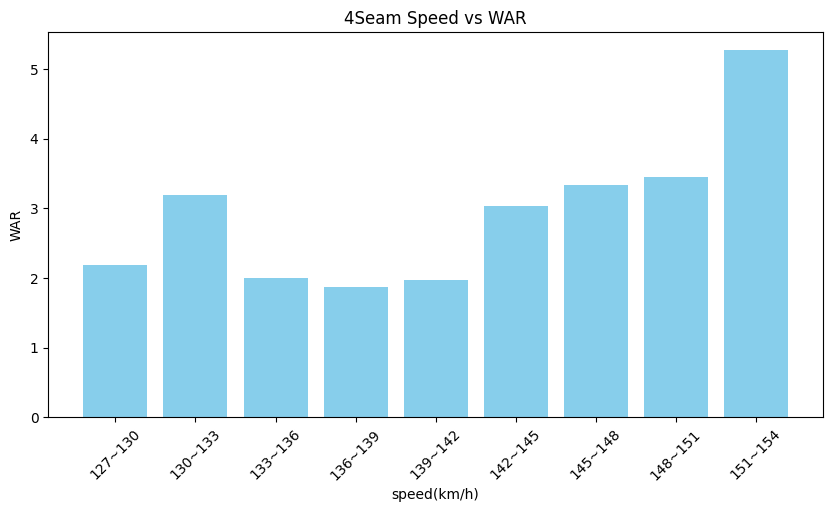

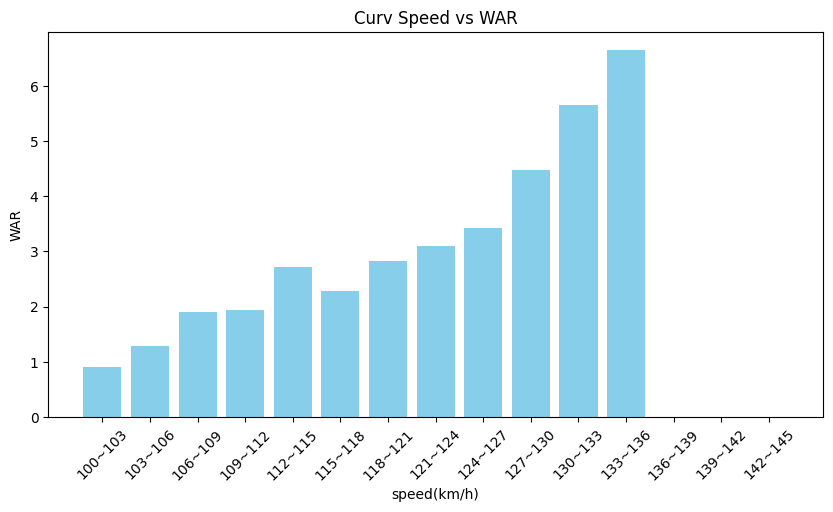

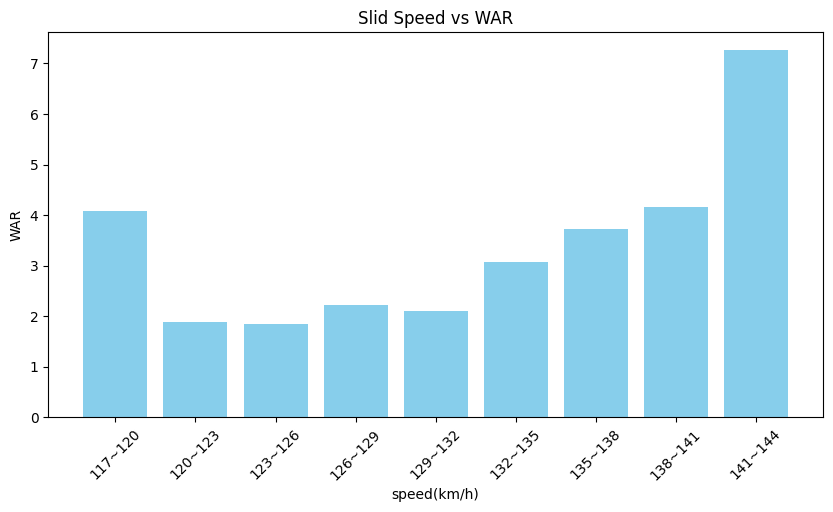

In [9]:
def analysis_speed(pitch_type):
    # Min, Max 조회
    min_speed = int(df_stats[f'SPEED_{pitch_type}'][df_stats[f'SPEED_{pitch_type}'] > 0].min())
    max_speed = int(df_stats[f'SPEED_{pitch_type}'].max()) + 1

    # min_speed에서 max_speed까지 크기가 3인 블럭으로 범위를 나누기
    block_size = 3
    blocks = {f'{i}~{i+block_size}':{'WAR':0, 'SIZE':0.0001} for i in range(min_speed, max_speed, block_size)}

    def find_block(speed):
        # 속도가 최소 속도 미만인 경우
        if speed < min_speed:
            return None  
        
        # 입력된 속도에 대한 블록 시작 값을 계산
        adjusted_speed = speed - min_speed
        block_start = min_speed + (adjusted_speed // block_size) * block_size
        block_end = block_start + block_size

        # 생성된 블록 키
        block_key = f'{int(block_start)}~{int(block_end)}'
        if block_key in blocks:
            return block_key
        return None

    # 데이터 가공
    for i in range(len(df_stats)):
        rate = df_stats[f'RATE_{pitch_type}'][i]
        speed = df_stats[f'SPEED_{pitch_type}'][i]
        war = df_stats['WAR'][i]

        block = find_block(speed)
        if block:
            blocks[block]['WAR'] += war * rate
            blocks[block]['SIZE'] += rate

    data_box = {b: blocks[b]['WAR']/blocks[b]['SIZE'] for b in blocks}

    # 그래프 출력
    title = f'{pitch_type} Speed vs WAR'
    x_label, y_label = 'speed(km/h)', 'WAR'
    draw_graph_bar(data_box,title=title, xlabel=x_label, ylabel=y_label)

# 구종 별 조회
pitch_types = ['4Seam', 'Curv', 'Slid']
for pitch_type in pitch_types:
    analysis_speed(pitch_type)